# Graph optimization with QAOA

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker
t = Tracker().start()

One application area where near-term quantum hardware is expected to shine is in graph optimization. Graph-based problems are interesting to explore because they have both strong links to practical use-cases (such as logistics and social networks) and are also often hard to solve.

<div align="center"><img src="graphs.png"/></div>

Graphs are composed of a collection of interconnected nodes. For example, here is a six-node graph:

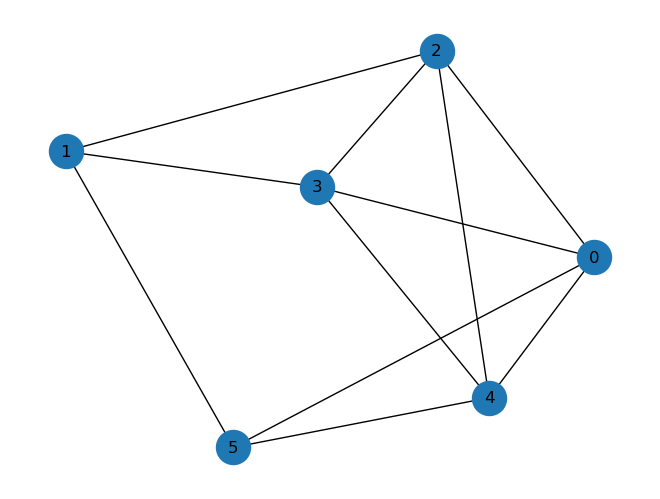

In [2]:
import networkx as nx

n_nodes = 6
p = 0.5  # probability of an edge
seed = 1967

g = nx.erdos_renyi_graph(n_nodes, p=p, seed=seed)
positions = nx.spring_layout(g, seed=seed)

nx.draw(g, with_labels=True, pos=positions, node_size=600)

Many practical use-cases can be mapped to a graph structure. In a social network, the nodes of a graph can represent users and the edges can represent connections between the users.

We often need to solve optimization problems to identify important properties of the graph. These problems can include:

- finding large clusters of fully connected nodes (known as [maximum clique](https://en.wikipedia.org/wiki/Clique_problem))
- finding a minimum number of nodes that connect to every edge in the graph (known as [minimum vertex cover](https://en.wikipedia.org/wiki/Vertex_cover))
- finding a partition of the nodes into two subsets so that the greatest number of edges are intersected (known as [maximum cut](https://en.wikipedia.org/wiki/Maximum_cut))

This tutorial shows how a quantum algorithm called QAOA can be run using PennyLane and Braket to solve graph-based optimization problems. We begin with a small 6-node graph and then push the limits to run a 20-node graph using parallel executions on SV1.

<div class="alert alert-block alert-info">
<b>Note</b> This notebook requires PennyLane version 0.17 or above.
</div>

## QAOA

The quantum approximate optimization algorithm (QAOA) is an algorithm designed for near-term hardware. It can find approximate solutions to combinatorial optimization problems such as graph-based problems.

QAOA is covered in more depth in the [QAOA_braket](../../hybrid_quantum_algorithms/QAOA/QAOA_braket.ipynb) notebook as well as in PennyLane [tutorials](https://pennylane.ai/qml/demos/tutorial_qaoa_intro.html). The following is a short summary to refresh the key concepts.


QAOA begins by associating the optimization problem with a cost Hamiltonian $H_C$ and choosing a mixer Hamiltonian $H_{M}$. It proceeds by repetitively applying multiple layers of the unitaries $\exp{(-i \gamma_i H_C)}$ and $\exp{(-i \alpha_i H_M)}$ with controllable parameters $\gamma_i$ and $\alpha_i$, as shown in the diagram below.

<div align="center"><img src="qaoa.png"/></div>

The algorithm then measures the cost Hamiltonian $H_C$. By varying the controllable parameters $\gamma_i$ and $\alpha_i$, the expectation value of the cost Hamiltonian is minimized. Applying the optimized unitaries prepares a quantum state that contains information about the optimal configuration for the problem. Sampling from the state will give a candidate solution.

<div class="alert alert-block alert-info">
<b>Summary</b> If you are less familiar with QAOA and quantum algorithms, the key takeaway message is that the algorithm involves an optimization of the controllable parameters $\gamma_i$ and $\alpha_i$ that the quantum circuit depends on. This can be tackled naturally using the PennyLane/Braket pipeline.
</div>

## Fixing the problem

Let's consider the graph above and aim to find the maximum clique, i.e., the largest set of nodes that are fully connected.

To solve this using QAOA in PennyLane and Braket, we first calculate the cost Hamiltonian $H_C$ and corresponding mixer Hamiltonian $H_M$

In [3]:
import pennylane as qml
from pennylane import numpy as np

cost_h, mixer_h = qml.qaoa.max_clique(g, constrained=False)
# constrained=True results in greater circuit depth but potentially better solutions

print("Cost Hamiltonian:\n", cost_h)
print("Mixer Hamiltonian:\n", mixer_h)

Cost Hamiltonian:
   (-0.5) [Z1]
+ (-0.5) [Z5]
+ (0.25) [Z0]
+ (0.25) [Z4]
+ (0.25) [Z2]
+ (0.25) [Z3]
+ (0.75) [Z0 Z1]
+ (0.75) [Z1 Z4]
+ (0.75) [Z2 Z5]
+ (0.75) [Z3 Z5]
Mixer Hamiltonian:
   (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]
+ (1) [X5]


## Setting up the algorithm

We begin by setting up a single QAOA layer

<div align="center"><img src="qaoa_layer.png"/></div>

This layer contains the controllable parameters $\gamma_i$ and $\alpha_i$.

In [4]:
def qaoa_layer(gamma, alpha):
    qml.qaoa.cost_layer(gamma, cost_h)
    qml.qaoa.mixer_layer(alpha, mixer_h)

The full QAOA circuit is then given by:

In [5]:
n_layers = 4
wires = n_nodes

def circuit(params, **kwargs):
    for i in range(wires):  # Prepare an equal superposition over all qubits
        qml.Hadamard(wires=i)
        
    qml.layer(qaoa_layer, n_layers, params[0], params[1])

<div class="alert alert-block alert-info">
<b>Note</b> We have chosen to use 4 QAOA layers. The choice of depth is a tradeoff between improved solutions (for greater depth) and increasing runtime.
</div>

There are overall eight controllable parameters: the first four are for $\gamma_i$ of the cost Hamiltonian and the second four are for $\alpha_i$ of the mixer Hamiltonian:

In [6]:
np.random.seed(1967)
params = np.random.uniform(size=[2, n_layers])
params

tensor([[0.72511958, 0.57312068, 0.6448612 , 0.55801009],
        [0.94368854, 0.93863944, 0.52819152, 0.5817428 ]], requires_grad=True)

For this part of the tutorial, we will use the local Braket simulator (see the [introduction tutorial](./0_Getting_started.ipynb) for further details):

In [7]:
dev = qml.device("braket.local.qubit", wires=wires)

The final step is to define the cost function. In QAOA, the output cost function is given by the expectation value of the cost Hamiltonian $H_C$, i.e.,

In [8]:
@qml.qnode(dev, diff_method='parameter-shift')
def cost_function(params, **kwargs):
    circuit(params)
    return qml.expval(cost_h)

## Running the algorithm

Now that we have set up the cost function, we just need to pick an optimizer and run the standard optimization loop.

In [9]:
optimizer = qml.GradientDescentOptimizer()

In [10]:
print("Initial cost:", cost_function(params))

for i in range(10):
    params = optimizer.step(cost_function, params)
    cost_eval = cost_function(params)
    print(f"Completed iteration {i + 1}, cost function:", cost_eval)

Initial cost: 0.6516478992954963
Completed iteration 1, cost function: -0.6687410127547252
Completed iteration 2, cost function: -1.7159072783906075
Completed iteration 3, cost function: -1.9501154582134768
Completed iteration 4, cost function: -2.0330929514098766
Completed iteration 5, cost function: -2.1057100865780685
Completed iteration 6, cost function: -2.1748317555275736
Completed iteration 7, cost function: -2.2428889625732786
Completed iteration 8, cost function: -2.31128304592676
Completed iteration 9, cost function: -2.380788701755378
Completed iteration 10, cost function: -2.45178556964876


## Investigating the result

How do we know how well the algorithm has performed? To do this, we can sample from the circuit using the optimized parameters. This will give us binary samples that allow us to select which nodes of the graph to use as part of our clique, e.g., either by simply selecting the most common sample or selecting the sample with the lowest corresponding energy.

Let's take some samples and see which ones occur most frequently. To start, we'll create a QNode designed for sampling.

In [11]:
shots = 100000
dev = qml.device("braket.local.qubit", wires=wires, shots=shots)

@qml.qnode(dev, diff_method='parameter-shift')
def samples(params):
    circuit(params)
    return np.array([qml.sample(qml.PauliZ(i)) for i in range(wires)])

Samples can now be generated and converted into probabilities:

In [12]:
from collections import Counter

s = samples(params).T
s = (1 - s.numpy()) / 2
s = map(tuple, s)

counts = Counter(s)
indx = np.ndindex(*[2] * wires)

probs = {p: counts.get(p, 0) / shots for p in indx}

We can now plot the probability distribution over all possible samples:

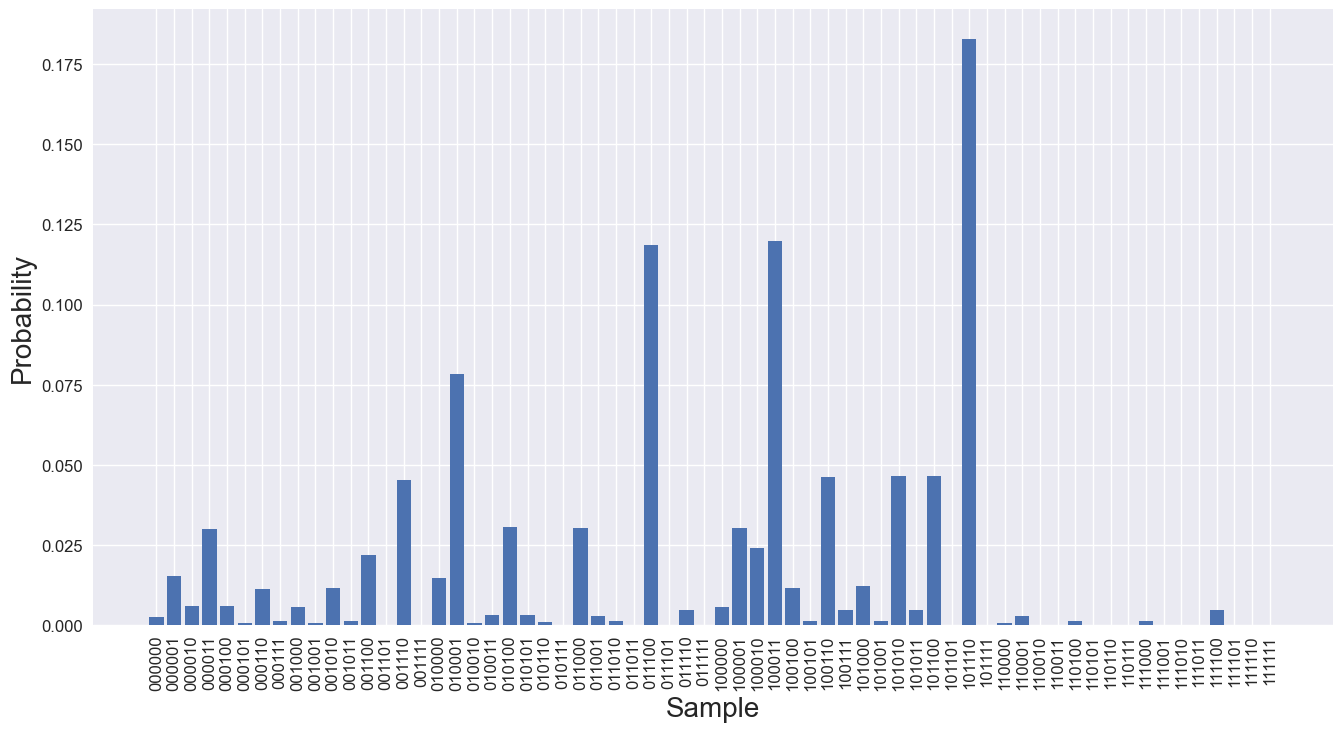

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("seaborn-v0_8")
labels = ["{0:{fill}6b}".format(i, fill='0') for i in range(len(probs))]

plt.bar(range(2 ** wires), probs.values())
plt.xticks([i for i in range(len(probs))], labels, rotation='vertical', size=12)
plt.yticks(size=12)

plt.xlabel("Sample", size=20)
plt.ylabel("Probability", size=20)

fig = plt.gcf()
fig.set_size_inches(16, 8)
plt.show()

From the plot, it is clear that the sample ``101110`` has the greatest probability. Since each qubit corresponds to a node, this sample selects the nodes ``[0, 2, 3, 4]`` to form a subgraph. Let's check if this is a clique, i.e., if all of the nodes are connected:

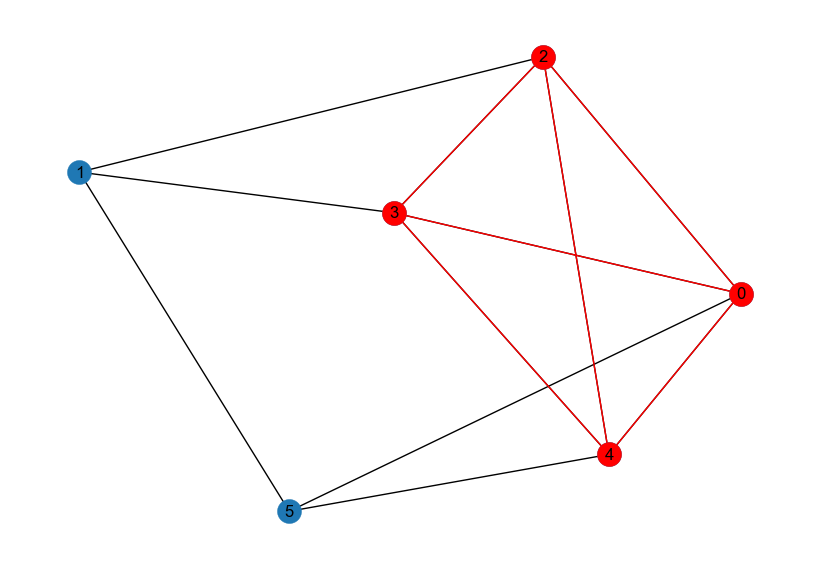

In [14]:
sub = g.subgraph([0, 2, 3, 4])
nx.draw(g, pos=positions, with_labels=True)
nx.draw(sub, pos=positions, node_color="r", edge_color="r")

Great, this is a clique! Moreover, it is the *largest* clique in this six-node graph. QAOA, using PennyLane and Braket, has helped us to solve the maximum clique problem!

## Scaling-up QAOA for larger graphs

We have seen how we can use PennyLane on Braket to solve graph optimization problems with QAOA. However, we have so far restricted to a simple six-node graph and used the local Braket device. Let's now be more ambitious and try to solve an optimization problem on a twenty-node graph!

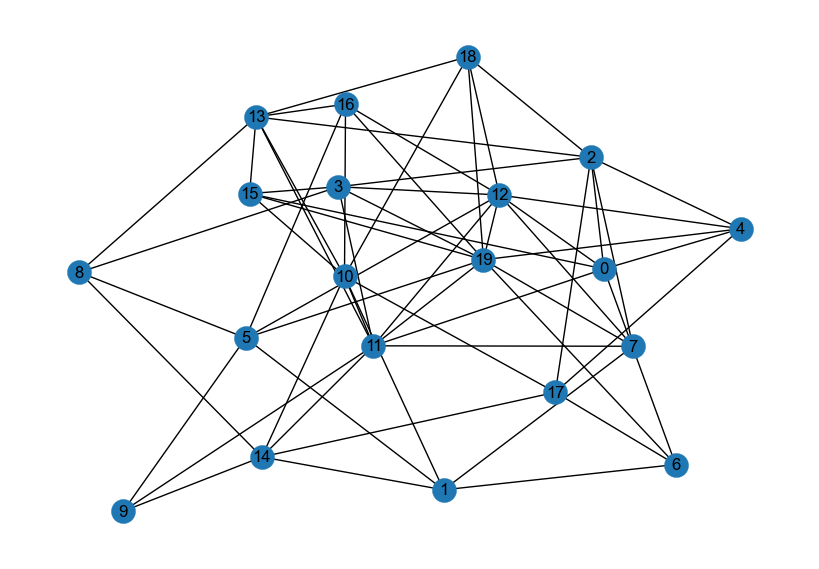

In [15]:
import networkx as nx

nodes = wires = 20
edges = 60
seed = 1967

g = nx.gnm_random_graph(nodes, edges, seed=seed)
positions = nx.spring_layout(g, seed=seed)

nx.draw(g, with_labels=True, pos=positions)

A twenty-node graph (which maps to the same number of qubits) definitely puts us in a regime where the local simulator will be slow to execute. As we have discussed in the [parallelization tutorial](../1_Parallelized_optimization_of_quantum_circuits/1_Parallelized_optimization_of_quantum_circuits.ipynb), this slowness will be compounded when it comes to training the circuit, with each optimization step resulting in multiple device executions due to calculation of the gradient. Thankfully, the remote SV1 simulator is highly suited to speeding up gradient calculations through parallelization. We now show that this makes training the circuit for QAOA solvable within a reasonable time.

Let's first load a new device:

In [16]:
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"

In [17]:
dev = qml.device(
    "braket.aws.qubit",
    device_arn=device_arn,
    wires=wires,
    parallel=True,
    max_parallel=20,
    poll_timeout_seconds=30,
)

Note the specification of ``max_parallel=20``. This means that up to ``20`` circuits will be executed in parallel on SV1 (the default value is ``10``).

<div class="alert alert-block alert-warning">
<b>Caution:</b> Increasing the maximum number of parallel executions can result in a greater rate of spending on simulation fees. The value must also be set bearing in mind your
    service <a href="https://docs.aws.amazon.com/braket/latest/developerguide/braket-quotas.html">quota</a>, which can be found <a href="https://console.aws.amazon.com/servicequotas/home">here</a>. Similarly, if you instead choose to run the QAOA problem on a QPU, it can take a long time and incur high <a href="https://aws.amazon.com/braket/pricing/">usage fees</a>. 
</div>

We now just need to set up the QAOA circuit and optimization problem in the same way as before. However, we will switch to a new optimization problem to keep things interesting: aiming to solve maximum cut, with the objective of partitioning the graph's nodes into two groups so that the greatest number of edges are shared between the groups (see the image below). This problem is NP-hard, so we expect it to be tough as we increase the number of graph nodes.

<div align="center"><img src="max-cut.png"/></div>

In [18]:
cost_h, mixer_h = qml.qaoa.maxcut(g)

In [19]:
def qaoa_layer(gamma, alpha):
    qml.qaoa.cost_layer(gamma, cost_h)
    qml.qaoa.mixer_layer(alpha, mixer_h)

In [20]:
n_layers = 2

@qml.qnode(dev, diff_method='device')
def cost_function(params, **kwargs):
    for i in range(wires):  # Prepare an equal superposition over all qubits
        qml.Hadamard(wires=i)
        
    qml.layer(qaoa_layer, n_layers, params[0], params[1])
    return qml.expval(cost_h)

In [21]:
np.random.seed(1967)
params = 0.01 * np.random.uniform(size=[2, n_layers])

A variety of [optimizers](https://pennylane.readthedocs.io/en/stable/introduction/optimizers.html) are available in PennyLane. Let's choose ``AdagradOptimizer``:

In [22]:
optimizer = qml.AdagradOptimizer(stepsize=0.1)

We're now set up to train the circuit! Note, if you are training this circuit yourself, you may want to increase the number of iterations in the optimization loop and also investigate changing the number of QAOA layers.

<div class="alert alert-block alert-warning">
<b>Caution:</b> Running the following cell will result in <a href="https://aws.amazon.com/braket/pricing/">usage fees</a> charged to your AWS account. The expected cost is less than $0.10 USD. Only run the cell if you are comfortable with the costs. We recommend monitoring the Billing & Cost Management Dashboard on the AWS console and being aware that tasks involving a large number of qubits can be costly.
</div>

In [23]:
import time

iterations = 10

for i in range(iterations):    
    t0 = time.time()
    
    params, cost_before = optimizer.step_and_cost(cost_function, params)    

    t1 = time.time()
    
    if i == 0:
        print("Initial cost:", cost_before)
    else:
        print(f"Cost at step {i}:", cost_before)

    print(f"Completed iteration {i + 1}")
    print(f"Time to complete iteration: {t1 - t0} seconds")

print(f"Cost at step {iterations}:", cost_function(params))

np.save("params.npy", params)
print("Parameters saved to params.npy")

Initial cost: -29.985702340959527
Completed iteration 1
Time to complete iteration: 11.593365669250488 seconds
Cost at step 1: -27.154071768632175
Completed iteration 2
Time to complete iteration: 7.950595855712891 seconds
Cost at step 2: -29.987262300062294
Completed iteration 3
Time to complete iteration: 9.728818655014038 seconds
Cost at step 3: -29.99916315360007
Completed iteration 4
Time to complete iteration: 7.955800533294678 seconds
Cost at step 4: -30.00215864604427
Completed iteration 5
Time to complete iteration: 8.598181962966919 seconds
Cost at step 5: -30.01205844401181
Completed iteration 6
Time to complete iteration: 7.819090843200684 seconds
Cost at step 6: -30.06370971261279
Completed iteration 7
Time to complete iteration: 7.722463607788086 seconds
Cost at step 7: -30.325223047053033
Completed iteration 8
Time to complete iteration: 9.111560106277466 seconds
Cost at step 8: -31.41103033197652
Completed iteration 9
Time to complete iteration: 7.728586912155151 second

This example shows us that a 20-qubit QAOA problem can be trained within around 10 seconds per iteration by using parallel executions on the Amazon Braket SV1 device to speed up gradient calculations. If this problem were run on the local Braket simulator without parallelization, we would expect for training to take much longer.

Pre-optimized parameters for the above 2-layer QAOA circuit after 30 iterations can be loaded with:

In [24]:
params_30 = np.load("params_30.npy")

<div class="alert alert-block alert-info">
<b>What's next?</b> See if you can analyze the trained QAOA circuit for the 20-node graph by adapting the earlier analysis. Also, check out the followup tutorial on quantum chemistry.
</div>

In [25]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD")

Quantum Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 0, 'tasks': {'COMPLETED': 11}, 'execution_duration': datetime.timedelta(seconds=38, microseconds=853000), 'billed_execution_duration': datetime.timedelta(seconds=38, microseconds=853000)}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 0.049 USD
